In [1]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()

In [2]:
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

In [16]:
rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl',map_location='cpu')

model.load_state_dict(checkpoint['model_state'])
model.eval()
# model.cuda()
print("Model loaded.")

Model loaded.


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


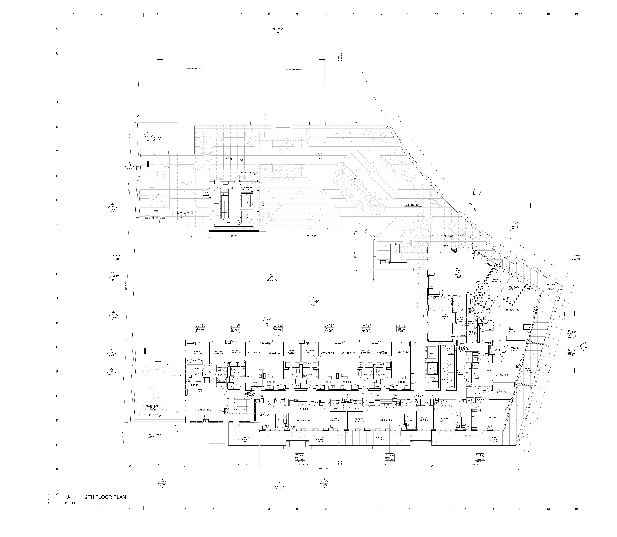

In [17]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

# Initialize the OCR reader (English language in this case)
reader = easyocr.Reader(['en'])

# Load the image
image_path = 'image4.png'  # Replace with your image path
image = cv2.imread(image_path)

# Save a copy of the original image (without bounding boxes)
original_image = image.copy()

# Get the image dimensions
img_height, img_width, _ = image.shape

# Number of rows and columns for the grid
rows, cols = 6, 6

# Calculate the height and width of each grid cell
cell_height = img_height // rows
cell_width = img_width // cols

# Run OCR to detect text in the image
results = reader.readtext(image)

# Create a list to store the count of bounding boxes in each grid cell
grid_counts = np.zeros((rows, cols), dtype=int)

# Loop through the OCR results and count bounding boxes in each grid cell
for (bbox, text, prob) in results:
    # Extract the coordinates of the bounding box
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple([int(x) for x in top_left])
    bottom_right = tuple([int(x) for x in bottom_right])

    # Draw the bounding box on the image
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    # Check which grid cell(s) the bounding box belongs to
    for i in range(rows):
        for j in range(cols):
            # Define the coordinates of the current grid cell
            cell_x_start = j * cell_width
            cell_x_end = (j + 1) * cell_width
            cell_y_start = i * cell_height
            cell_y_end = (i + 1) * cell_height
            
            # Check if the bounding box overlaps the current cell
            if (top_left[0] < cell_x_end and bottom_right[0] > cell_x_start and
                top_left[1] < cell_y_end and bottom_right[1] > cell_y_start):
                grid_counts[i, j] += 1

# Check if there are 2 or more cells in the 5th or 6th column with counts > 20
col_5_count = np.sum(grid_counts[:, 4] > 20)  # 5th column
col_6_count = np.sum(grid_counts[:, 5] > 20)  # 6th column

# Crop out the 5th or 6th column if they have 2 or more cells with count > 20
cropped_image = original_image  # Start with the original image for cropping

if col_5_count >= 2:
    # Crop out the 5th column from the original image
    cropped_image = cropped_image[:, :4 * cell_width]  # Keep only columns 1 to 4

if col_6_count >= 2:
    # Crop out the 6th column as well
    cropped_image = cropped_image[:, :5 * cell_width]  # Keep only columns 1 to 5

# Display the cropped image (without bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Original image shape: (7200, 8000, 3)
Top Left: 5 rooms detected, 2 walls detected.
Top Right: 0 rooms detected, 0 walls detected.
Bottom Left: 8 rooms detected, 4 walls detected.
Bottom Right: 9 rooms detected, 3 walls detected.
Full room segmentation and icon segmentation completed.
Total rooms detected: 22
Total walls detected: 9
Total walls from full segmentation: 770790
Total rooms from full segmentation: 11


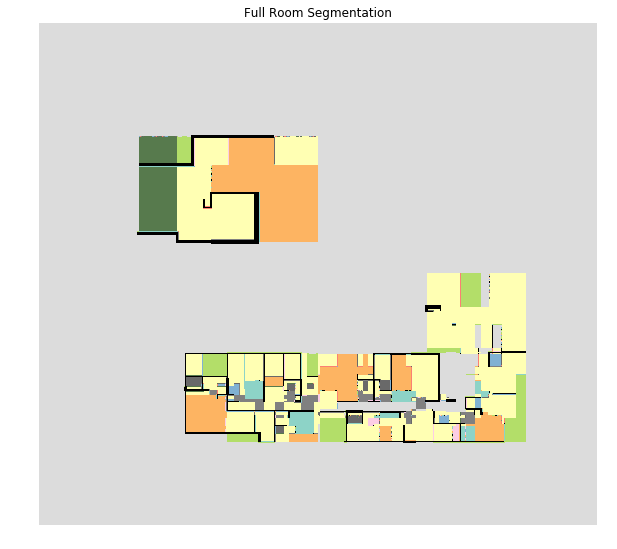

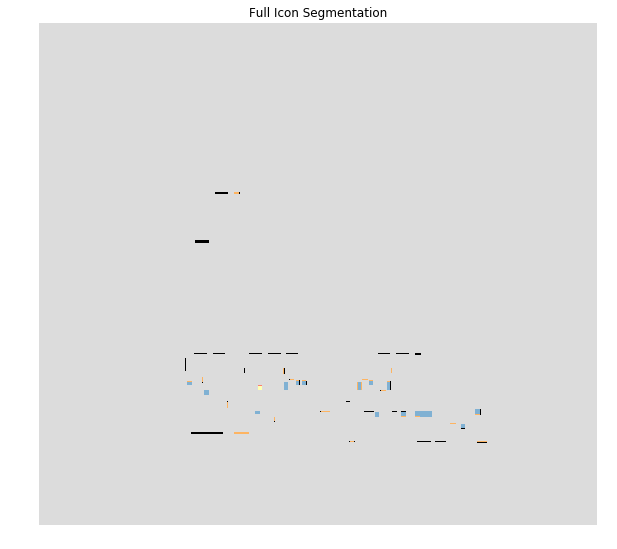

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the large blueprint image
image = cropped_image

# Check if the image was loaded successfully
if image is None:
    print(f"Error: Could not load image at {image_path}")
else:
    # Print the original shape of the image
    print(f"Original image shape: {image.shape}")

    # Get the height and width of the original image
    height, width, _ = image.shape

    # Split the image into 4 quadrants
    mid_x, mid_y = width // 2, height // 2
    top_left = image[:mid_y, :mid_x]
    top_right = image[:mid_y, mid_x:]
    bottom_left = image[mid_y:, :mid_x]
    bottom_right = image[mid_y:, mid_x:]

    quadrants = [top_left, top_right, bottom_left, bottom_right]
    quadrant_names = ["Top Left", "Top Right", "Bottom Left", "Bottom Right"]

    # Placeholder for full room segmentation and icon segmentation
    full_room_segmentation = np.zeros((height, width), dtype=np.int32)
    full_icon_segmentation = np.zeros((height, width), dtype=np.int32)

    total_rooms = 0
    total_walls = 0

    # Loop through each quadrant, resize, and perform predictions
    for idx, quadrant in enumerate(quadrants):
        # Resize each quadrant to the model input size (e.g., 800x800)
        target_size = (800, 800)
        resized_quadrant = cv2.resize(quadrant, target_size, interpolation=cv2.INTER_AREA)
        
        # Convert BGR to RGB for correct display
        resized_image_rgb = cv2.cvtColor(resized_quadrant, cv2.COLOR_BGR2RGB)

        # Convert image to PyTorch tensor and normalize it
        resized_image_tensor = torch.from_numpy(resized_image_rgb).float() / 255.0  # Normalize image to [0, 1]
        resized_image_tensor = resized_image_tensor.permute(2, 0, 1).unsqueeze(0)  # Change to [batch, channels, height, width]

        # Perform the prediction using the pre-loaded model
        model.eval()
        with torch.no_grad():
            prediction = model(resized_image_tensor)

        # Post-process the prediction to extract heatmaps, rooms, and icons
        img_size = (800, 800)
        n_classes = 44
        split = [21, 12, 11]  # Adjust based on room and icon classes

        heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
        polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

        # Convert predictions back to image format for visualization
        pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, 800, 800)

        # Count rooms and walls for the current quadrant
        num_rooms = np.unique(pol_room_seg)[1:]  # Ignore background (assuming it has index 0)
        num_walls = np.unique(pol_icon_seg)[1:]  # Adjust this based on your wall detection class

        # Store counts for the current quadrant
        print(f"{quadrant_names[idx]}: {len(num_rooms)} rooms detected, {len(num_walls)} walls detected.")

        # Update total counts
        total_rooms += len(num_rooms)
        total_walls += len(num_walls)

        # Assign each quadrant's segmentation result to the full image
        if idx == 0:  # Top Left
            full_room_segmentation[:mid_y, :mid_x] = cv2.resize(pol_room_seg, (mid_x, mid_y))
            full_icon_segmentation[:mid_y, :mid_x] = cv2.resize(pol_icon_seg, (mid_x, mid_y))
        elif idx == 1:  # Top Right
            full_room_segmentation[:mid_y, mid_x:] = cv2.resize(pol_room_seg, (mid_x, mid_y))
            full_icon_segmentation[:mid_y, mid_x:] = cv2.resize(pol_icon_seg, (mid_x, mid_y))
        elif idx == 2:  # Bottom Left
            full_room_segmentation[mid_y:, :mid_x] = cv2.resize(pol_room_seg, (mid_x, mid_y))
            full_icon_segmentation[mid_y:, :mid_x] = cv2.resize(pol_icon_seg, (mid_x, mid_y))
        elif idx == 3:  # Bottom Right
            full_room_segmentation[mid_y:, mid_x:] = cv2.resize(pol_room_seg, (mid_x, mid_y))
            full_icon_segmentation[mid_y:, mid_x:] = cv2.resize(pol_icon_seg, (mid_x, mid_y))

    # Now we have a full-room segmentation result
    print("Full room segmentation and icon segmentation completed.")

    # Display total counts
    print(f"Total rooms detected: {total_rooms}")
    print(f"Total walls detected: {total_walls}")

    # --- Count Walls and Rooms in Full Segmentation ---
    room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room", "Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
    wall_class = room_classes.index("Wall")  # e.g., index 2 based on the room_classes list

    def find_walls_and_rooms(full_room_segmentation, wall_class, room_classes):
        """
        Identifies the number of walls and rooms in a segmented image.

        :param full_room_segmentation: Segmented image where different classes are represented as pixel values.
        :param wall_class: The pixel value corresponding to the wall class.
        :param room_classes: A list of pixel values corresponding to room classes.
        :return: A tuple containing the count of walls and rooms.
        """
        walls = np.sum(full_room_segmentation == wall_class)
        rooms = np.unique(full_room_segmentation)
        room_count = len(rooms) - 1  # Subtract 1 for the background class (0)
        return walls, room_count

    # Get counts from the full segmentation
    total_walls_full, total_rooms_full = find_walls_and_rooms(full_room_segmentation, wall_class, room_classes)

    print(f"Total walls from full segmentation: {total_walls_full}")
    print(f"Total rooms from full segmentation: {total_rooms_full}")

    # Display segmented full room image
    def display_segmented_image(segmentation, title):
        plt.figure(figsize=(10, 10))
        plt.title(title)
        plt.imshow(segmentation, cmap='rooms')  # Use colormap to visualize segmentation
        plt.axis('off')  # Turn off axis
        plt.show()

    # Display the full room segmentation
    display_segmented_image(full_room_segmentation, "Full Room Segmentation")

    # Optionally display the icon segmentation as well
    display_segmented_image(full_icon_segmentation, "Full Icon Segmentation")


In [22]:
from fastapi import FastAPI, File, UploadFile

In [23]:
import io
import cv2
import numpy as np
from fastapi import FastAPI, File, UploadFile
from PIL import Image
import torch
import easyocr
import matplotlib.pyplot as plt
from typing import Dict

In [25]:
import uvicorn